NGD: Already stationary
LDZ: Already stationary
GTP: Already stationary
IND: Already stationary
HDD: Already stationary
HDD-1: Already stationary
Workday: Already stationary
War: First difference
Rus: First difference
FR nuclear: Already stationary
DE nuclear: First difference
DE wind: Already stationary
DE solar: Already stationary
THE price: Already stationary
DE IND index: Already stationary
EU storage: Already stationary
EU LNG: First difference
UK NL production: First difference
Norway sendout: Already stationary
African TAP: First difference


/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/e

                       NGD           LDZ           GTP           IND
HDD               0.505135  4.117872e-01  9.871278e-01  7.383844e-01
HDD-1             0.009875  2.189385e-09  4.650660e-01  2.174962e-01
Workday           0.000023  1.597255e-01  7.107269e-03  4.273597e-10
War               0.255888  7.720960e-02  9.510993e-01  6.804465e-01
Rus               0.552164  9.664466e-01  4.102880e-01  6.081805e-01
FR nuclear        0.000598  3.584041e-02  6.859684e-07  1.632589e-04
DE nuclear        0.015372  1.827201e-01  4.089679e-01  4.619910e-02
DE wind           0.000870  2.757127e-01  7.680565e-02  1.570325e-01
DE solar          0.005428  3.521051e-03  4.678988e-01  3.311301e-03
THE price         0.642332  7.704626e-02  7.818022e-01  6.955187e-01
DE IND index      0.727499  7.317470e-01  1.919048e-03  9.085831e-01
EU storage        0.082682  4.192366e-02  8.636291e-01  2.473321e-01
EU LNG            0.007444  3.484571e-01  6.697894e-01  4.474083e-02
UK NL production  0.012353  9.0480

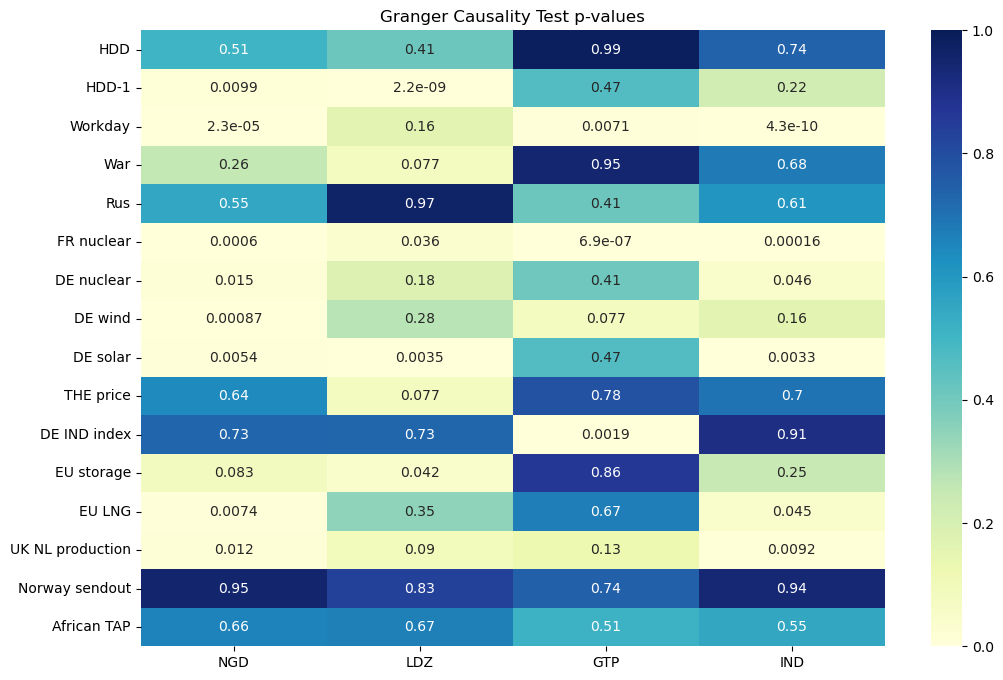

In [45]:
# This script performs the Granger Causality Test on the NGD data.

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Define dependent variables and predictors
dependent_vars = ['NGD', 'LDZ', 'GTP', 'IND']
predictors = ['HDD','HDD-1','Workday','War','Rus','FR nuclear', 'DE nuclear', 'DE wind', 'DE solar', 'THE price', 'DE IND index', 'EU storage', 'EU LNG', 'UK NL production', 'Norway sendout', 'African TAP']

# ADF test function
def adf_test(timeseries):
    timeseries = timeseries.dropna()  # Drop NaN values before ADF test
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # Return True if data is stationary

def make_stationary(series_data):
    # If already stationary
    if adf_test(series_data):
        return series_data, "Already stationary"

    # 2a. First difference
    diff_data = series_data.diff().dropna()
    if adf_test(diff_data):
        return diff_data, "First difference"

    # 2b. log
    log_data = np.log1p(series_data)  # Using log1p to handle 0 values
    if adf_test(log_data):
        return log_data, "Logarithm"

    # 2c. Logarithm and then First Difference
    log_diff_data = log_data.diff().dropna()
    if adf_test(log_diff_data):
        return log_diff_data, "Logarithm then First difference"
    
    # 2d. seasonal_decompose
    decomposition = seasonal_decompose(series_data.dropna(), model='additive', freq=365)
    residuals = decomposition.resid.dropna()
    if adf_test(residuals):
        # Plotting the components
        decomposition.plot()
        plt.show()
        return residuals, "Seasonal Decompose"
    
    return series_data, "Still non-stationary"

# Process the series
all_series = dependent_vars + predictors
methods_used = {}

for series in all_series:
    ngd_data[series], method = make_stationary(ngd_data[series])
    methods_used[series] = method

# Print methods used
for series, method in methods_used.items():
    print(f"{series}: {method}")

# Remove any infinite or NaN values introduced by the transformations
ngd_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ngd_data.dropna(inplace=True)

lags = [1]
results = {}
all_stationary = True  # Initial assumption

# Loop over dependent variables and predictors
for dep_var in dependent_vars:
    results[dep_var] = {}
    
    for pred in predictors:
        # 2. Extract the subset for the current predictor and dependent variable
        temp_data = ngd_data[[dep_var, pred]]
        
        # 3. Drop NaN values for this subset
        temp_data = temp_data.dropna()

        # 4. Check if both series are stationary
        for series_name in [dep_var, pred]:
            if not adf_test(temp_data[series_name]):
                # 5. If not stationary, run make_stationary to make it stationary
                temp_data[series_name], _ = make_stationary(temp_data[series_name])
                temp_data.dropna(inplace=True)  # Drop NaN values after transformations
                
                # 6. Double check if the result is stationary
                if not adf_test(temp_data[series_name]):
                    print(f"{series_name} in the pair ({dep_var}, {pred}) is still not stationary after transformation. Skipping this pair.")
                    continue

        # Check if both series within the temp_data have enough non-NaN data points.
        if temp_data.isna().any().any() or (temp_data.shape[0] < max(lags)*2):
            print(f"Insufficient data for the pair ({dep_var}, {pred}). Skipping this pair.")
            continue

        # 7. If data are stationary, run grangercausalitytests
        for lag in lags:
            test_result = grangercausalitytests(temp_data, maxlag=lag, verbose=False)
            p_value = test_result[lag][0]['ssr_ftest'][1]
            results[dep_var][pred] = p_value

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results in a table format
print(results_df)

# Plot the results as a heatmap for easier visual interpretation
plt.figure(figsize=(12, 8))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title('Granger Causality Test p-values')
plt.show()


In [5]:
#Only stationary test using ADF and KPSS test

import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Define dependent variables and predictors
dependent_vars = ['NGD', 'LDZ', 'GTP', 'IND']
predictors = ['HDD','HDD-1','Workday','War','Rus','FR nuclear', 'DE wind', 'DE solar', 'THE price', 'DE IND index', 'EU storage', 'EU LNG', 'UK NL production', 'Norway sendout', 'African TAP']

all_series = dependent_vars + predictors

# ADF and KPSS test function
def adf_kpss_test(series):
    # Drop NaN values before testing
    series = series.dropna()
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    adf_pvalue = adf_result[1]
    # KPSS Test
    kpss_result = kpss(series, regression='c')
    kpss_pvalue = kpss_result[1]

    return adf_pvalue, kpss_pvalue


# Test each series for stationarity using ADF and KPSS tests
results = {}
for series_name in dependent_vars + predictors:
    adf_pvalue, kpss_pvalue = adf_kpss_test(ngd_data[series_name])
    results[series_name] = {
        'ADF p-value': adf_pvalue,
        'KPSS p-value': kpss_pvalue,
        'Is Stationary ADF': adf_pvalue < 0.05,
        'Is Stationary KPSS': kpss_pvalue >= 0.05  # KPSS null hypothesis is the presence of stationarity
    }

results_df = pd.DataFrame(results).T  # Convert to a DataFrame for a nicer display
results_df

/var/folders/vd/7gcd_vrj2nb1qm1dm3sczg_h0000gn/T/ipykernel_48247/2843455827.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/vd/7gcd_vrj2nb1qm1dm3sczg_h0000gn/T/ipykernel_48247/2843455827.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/vd/7gcd_vrj2nb1qm1dm3sczg_h0000gn/T/ipykernel_48247/2843455827.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/vd/7gcd_vrj2nb1qm1dm3sczg_h0000gn/T/ipykernel_48247/2843455827.py:24: InterpolationWarning: The test s

,ADF p-value,KPSS p-value,Is Stationary ADF,Is Stationary KPSS
NGD,0.002858,0.1,True,True
LDZ,0.001478,0.1,True,True
GTP,0.000042,0.01,True,False
IND,0.003921,0.032708,True,False
HDD,0.003435,0.1,True,True
HDD-1,0.003343,0.1,True,True
Workday,0.0,0.1,True,True
War,0.9134,0.01,False,False
Rus,0.573928,0.01,False,False
FR nuclear,0.006311,0.01,True,False


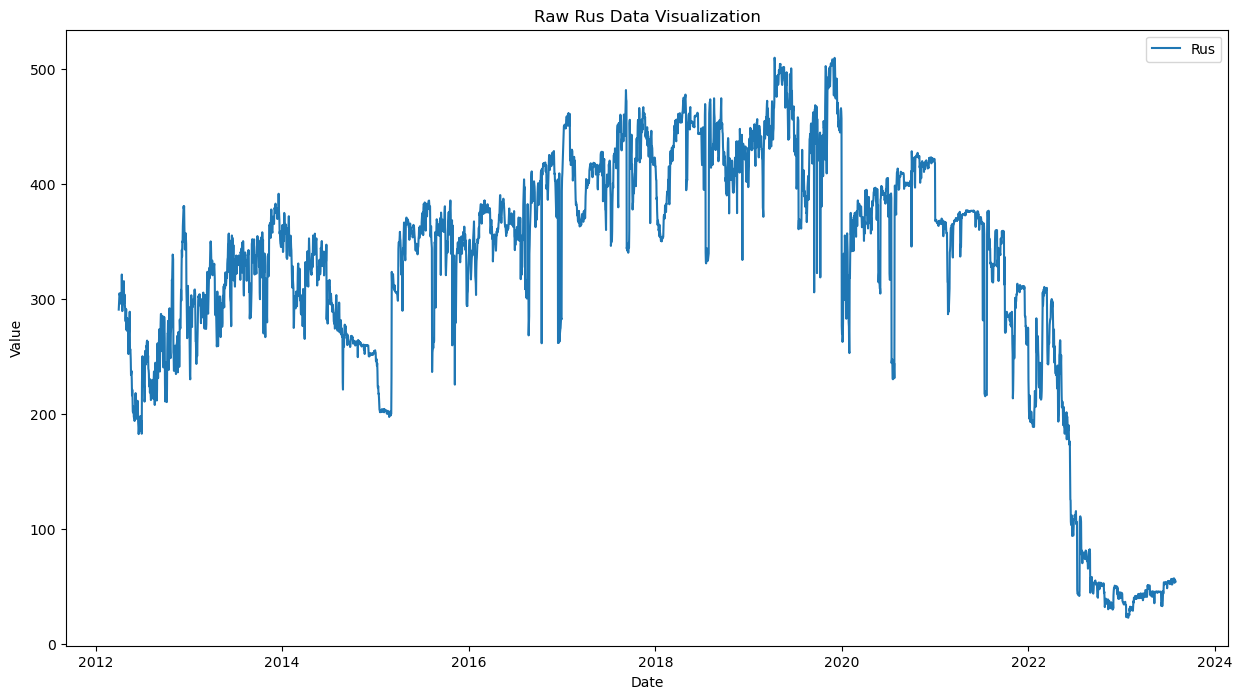

The series 'Rus' is stationary after transformations.


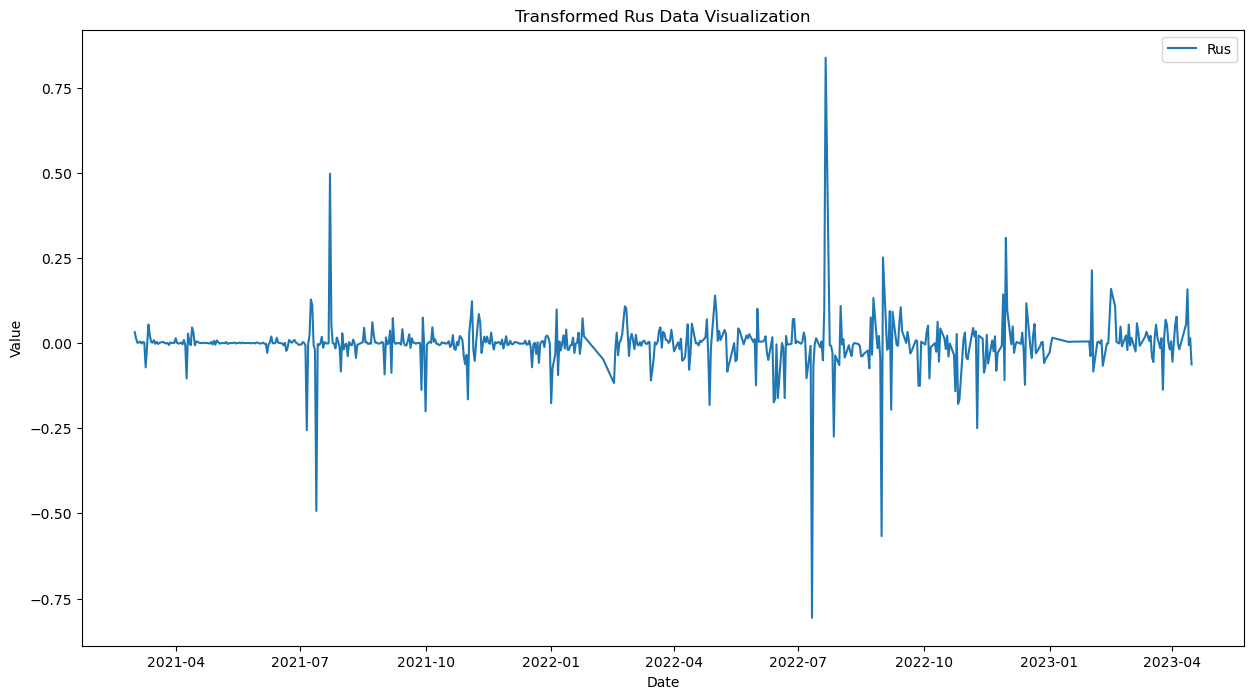

In [1]:
# Stationary test with transformation

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

# ADF test function
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # Return True if data is stationary

# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
plt.plot(ngd_data['Date'], ngd_data['Rus'], label='Rus')
plt.title("Raw Rus Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Drop NaN values in the 'Rus' series
ngd_data.dropna(subset=['Rus'], inplace=True)

# Transform series if it's not stationary
series = 'Rus'

if not adf_test(ngd_data[series]):
    ngd_data[series] = np.log(ngd_data[series])
    ngd_data[series] = ngd_data[series].diff()
    ngd_data.dropna(inplace=True)

if not adf_test(ngd_data[series]):
    decomposition = seasonal_decompose(ngd_data[series], model='additive', freq=365)
    residuals = decomposition.resid.dropna()
    ngd_data[series] = residuals

if not adf_test(ngd_data[series]):
    ngd_data[series] = ngd_data[series].diff(12)
    ngd_data.dropna(inplace=True)

if not adf_test(ngd_data[series]):
    ngd_data[series], _ = boxcox(ngd_data[series] + 1 - min(ngd_data[series]))

# Check the stationarity of the new series and visualize
plt.figure(figsize=(15, 8))
if not adf_test(ngd_data[series]):
    print(f"The series '{series}' is still not stationary after transformations.")
else:
    plt.plot(ngd_data['Date'], ngd_data[series], label=series)
    print(f"The series '{series}' is stationary after transformations.")
plt.title("Transformed Rus Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


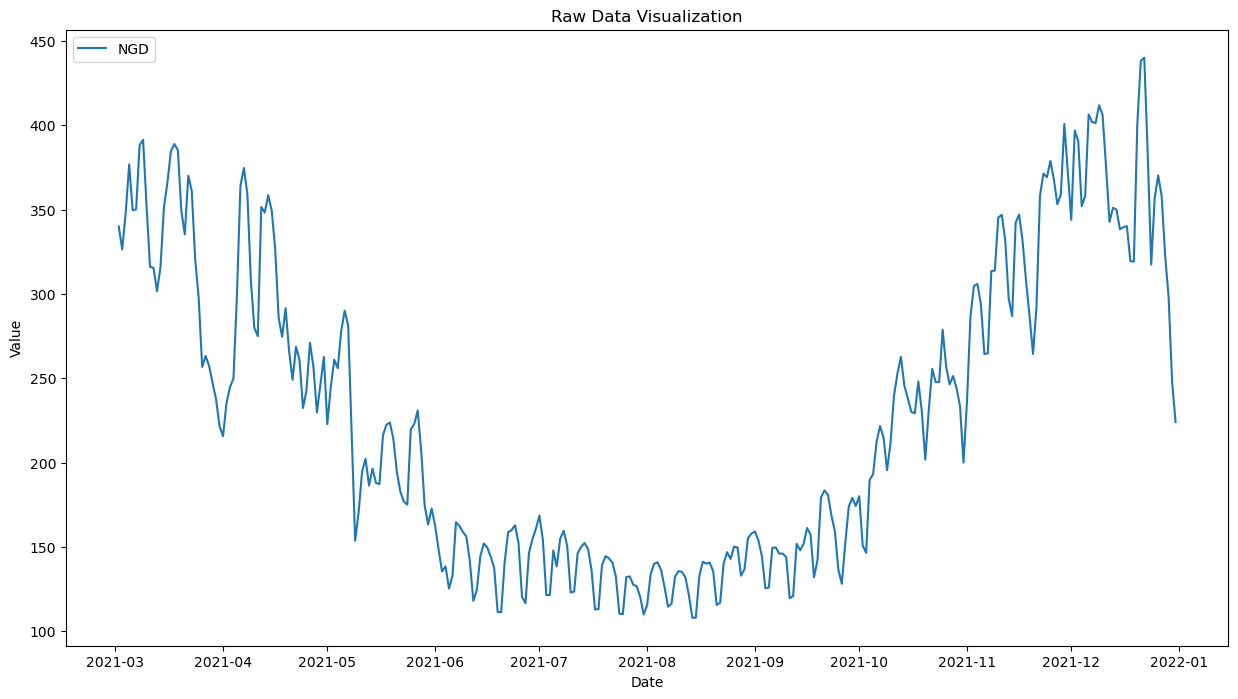

Logarithm and first difference transformation made the series stationary.
Series is already stationary.
Series is already stationary.
The series 'NGD' is stationary after transformations.


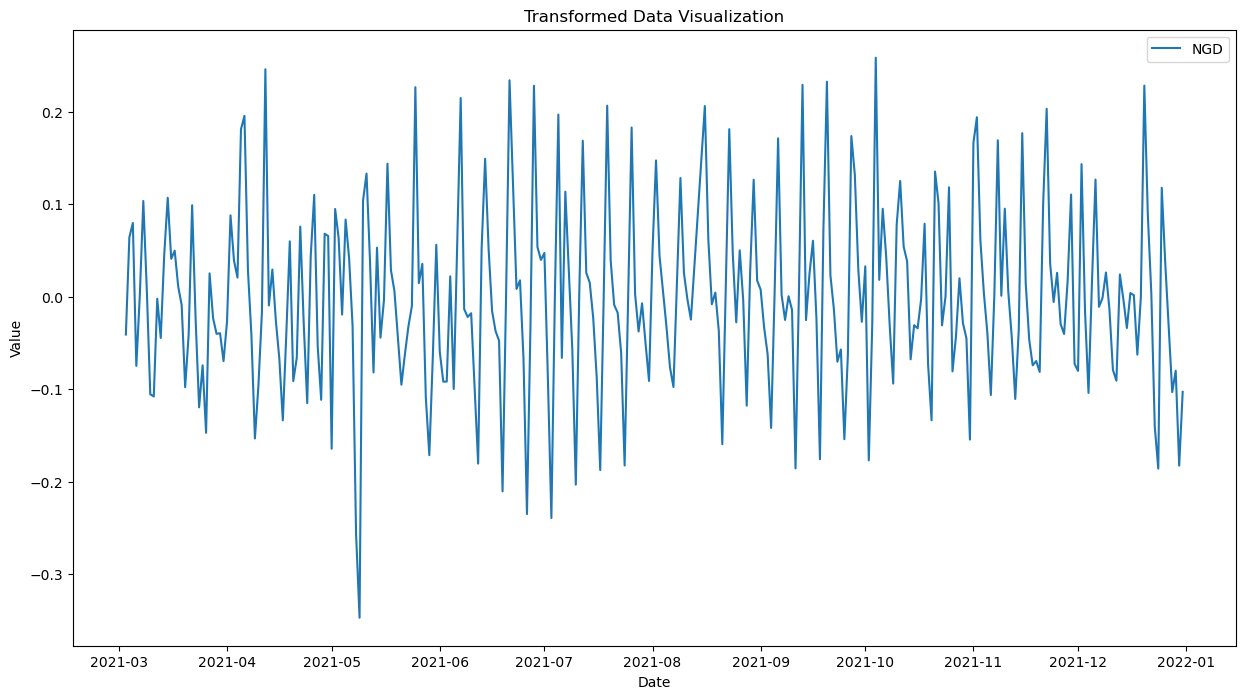

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

# ADF test function
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # Return True if data is stationary

# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Filter data from 2021/3/2 to 2021/12/31
ngd_data = ngd_data[(ngd_data['Date'] >= '2021-03-02') & (ngd_data['Date'] <= '2021-12-31')]

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
plt.plot(ngd_data['Date'], ngd_data['NGD'], label='NGD')
plt.title("Raw Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Transform series if it's not stationary
series = 'NGD'

if not adf_test(ngd_data[series]):
    ngd_data[series] = np.log(ngd_data[series])
    ngd_data[series] = ngd_data[series].diff()
    ngd_data.dropna(inplace=True)
    if adf_test(ngd_data[series]):
        print("Logarithm and first difference transformation made the series stationary.")
else:
    print("Series is already stationary.")

if not adf_test(ngd_data[series]):
    decomposition = seasonal_decompose(ngd_data[series], model='additive', freq=365)
    residuals = decomposition.resid.dropna()
    if adf_test(residuals):
        print("Decomposition made the series stationary.")
        plt.figure(figsize=(15, 8))
        plt.subplot(4, 1, 1)
        plt.plot(decomposition.observed)
        plt.title('Observed')
        plt.subplot(4, 1, 2)
        plt.plot(decomposition.trend)
        plt.title('Trend')
        plt.subplot(4, 1, 3)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonal')
        plt.subplot(4, 1, 4)
        plt.plot(decomposition.resid)
        plt.title('Residual')
        plt.tight_layout()
        plt.show()

        ngd_data[series] = residuals
    else:
        print("Decomposition did not make the series stationary.")

if not adf_test(ngd_data[series]):
    ngd_data[series] = ngd_data[series].diff(12)
    ngd_data.dropna(inplace=True)
    if adf_test(ngd_data[series]):
        print("Higher order differencing made the series stationary.")
else:
    print("Series is already stationary.")

if not adf_test(ngd_data[series]):
    ngd_data[series], _ = boxcox(ngd_data[series] + 1 - min(ngd_data[series]))
    if adf_test(ngd_data[series]):
        print("Box-Cox transformation made the series stationary.")
else:
    print("Series is already stationary.")

# Check the stationarity of the new series and visualize
plt.figure(figsize=(15, 8))
if not adf_test(ngd_data[series]):
    print(f"The series '{series}' is still not stationary after transformations.")
else:
    plt.plot(ngd_data['Date'], ngd_data[series], label=series)
    print(f"The series '{series}' is stationary after transformations.")
plt.title("Transformed Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


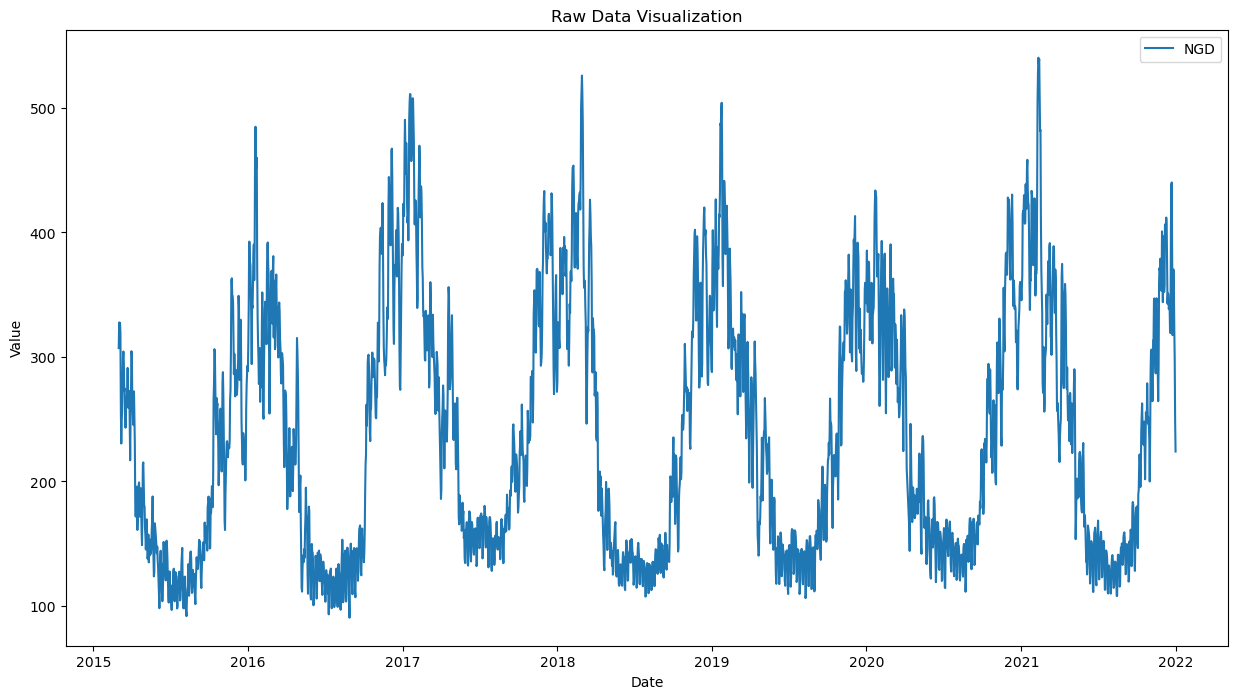

The series 'NGD' is stationary after transformations.


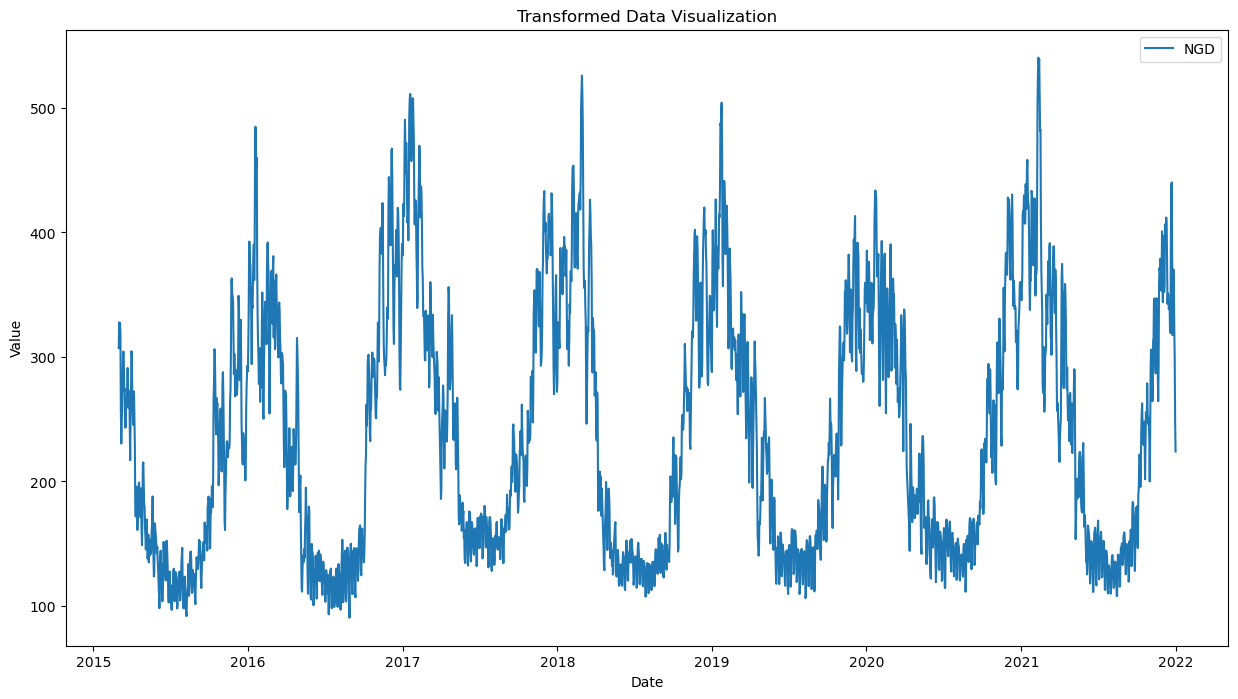

In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

# ADF test function
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # Return True if data is stationary

# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Filter data from 2021/3/2 to 2021/12/31
ngd_data = ngd_data[(ngd_data['Date'] >= '2015-03-02') & (ngd_data['Date'] <= '2021-12-31')]

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
plt.plot(ngd_data['Date'], ngd_data['NGD'], label='NGD')
plt.title("Raw Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Transform series if it's not stationary
series = 'NGD'

# 1. First Difference
if not adf_test(ngd_data[series]):
    ngd_data[series] = ngd_data[series].diff()
    ngd_data.dropna(inplace=True)
    if adf_test(ngd_data[series]):
        print("First difference transformation made the series stationary.")
        
# 2. Log Transformation
if not adf_test(ngd_data[series]):
    ngd_data[series] = np.log(ngd_data[series])
    if adf_test(ngd_data[series]):
        print("Logarithm transformation made the series stationary.")

# 3. Logarithm and First Difference
if not adf_test(ngd_data[series]):
    ngd_data[series] = np.log(ngd_data[series]).diff()
    ngd_data.dropna(inplace=True)
    if adf_test(ngd_data[series]):
        print("Logarithm and first difference transformation made the series stationary.")

# 4. Decomposition
if not adf_test(ngd_data[series]):
    decomposition = seasonal_decompose(ngd_data[series], model='additive')
    residuals = decomposition.resid.dropna()
    if adf_test(residuals):
        print("Decomposition made the series stationary.")
        
        plt.figure(figsize=(15, 8))
        plt.subplot(4, 1, 1)
        plt.plot(decomposition.observed)
        plt.title('Observed')
        plt.subplot(4, 1, 2)
        plt.plot(decomposition.trend)
        plt.title('Trend')
        plt.subplot(4, 1, 3)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonal')
        plt.subplot(4, 1, 4)
        plt.plot(decomposition.resid)
        plt.title('Residual')
        plt.tight_layout()
        plt.show()

        ngd_data[series] = residuals

# 5. Higher order differencing
if not adf_test(ngd_data[series]):
    ngd_data[series] = ngd_data[series].diff(2)
    ngd_data.dropna(inplace=True)
    if adf_test(ngd_data[series]):
        print("Higher order differencing made the series stationary.")

# 6. Box-Cox Transformation
if not adf_test(ngd_data[series]):
    ngd_data[series], _ = boxcox(ngd_data[series] + 1 - min(ngd_data[series]))
    if adf_test(ngd_data[series]):
        print("Box-Cox transformation made the series stationary.")

# Check the stationarity of the new series and visualize
plt.figure(figsize=(15, 8))
if not adf_test(ngd_data[series]):
    print(f"The series '{series}' is still not stationary after transformations.")
else:
    plt.plot(ngd_data['Date'], ngd_data[series], label=series)
    print(f"The series '{series}' is stationary after transformations.")
plt.title("Transformed Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


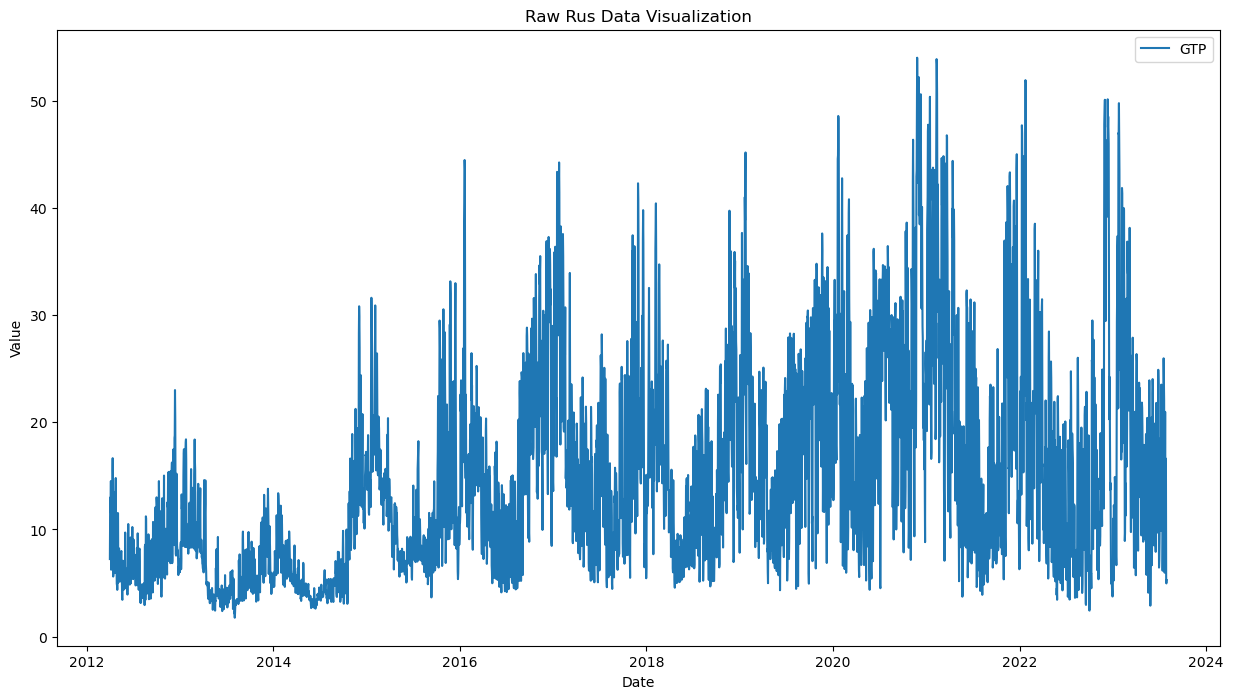

The series is already stationary.


In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns


# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
plt.plot(ngd_data['Date'], ngd_data['GTP'], label='GTP')
plt.title("Raw Rus Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Drop NaN values in the 'Rus' series
ngd_data.dropna(subset=['GTP'], inplace=True)

# ADF test function
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # Return True if data is stationary

# Transform series if it's not stationary
series_name = 'GTP'
series = ngd_data[series_name]

# Check the stationarity of the series
if not adf_test(series):
    # Decompose the series
    decomposition = seasonal_decompose(series, model='additive')
    
    # Check the stationarity of the residuals
    residuals = decomposition.resid.dropna()
    if adf_test(residuals):
        print("Decomposition made the series stationary.")
        ngd_data[series_name] = residuals

        # Plot the decomposed components
        plt.figure(figsize=(15, 8))
        plt.subplot(4, 1, 1)
        plt.plot(decomposition.observed)
        plt.title('Observed')
        plt.subplot(4, 1, 2)
        plt.plot(decomposition.trend)
        plt.title('Trend')
        plt.subplot(4, 1, 3)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonal')
        plt.subplot(4, 1, 4)
        plt.plot(decomposition.resid)
        plt.title('Residual')
        plt.tight_layout()
        plt.show()
    else:
        print("Decomposition did not make the series stationary.")
else:
    print("The series is already stationary.")


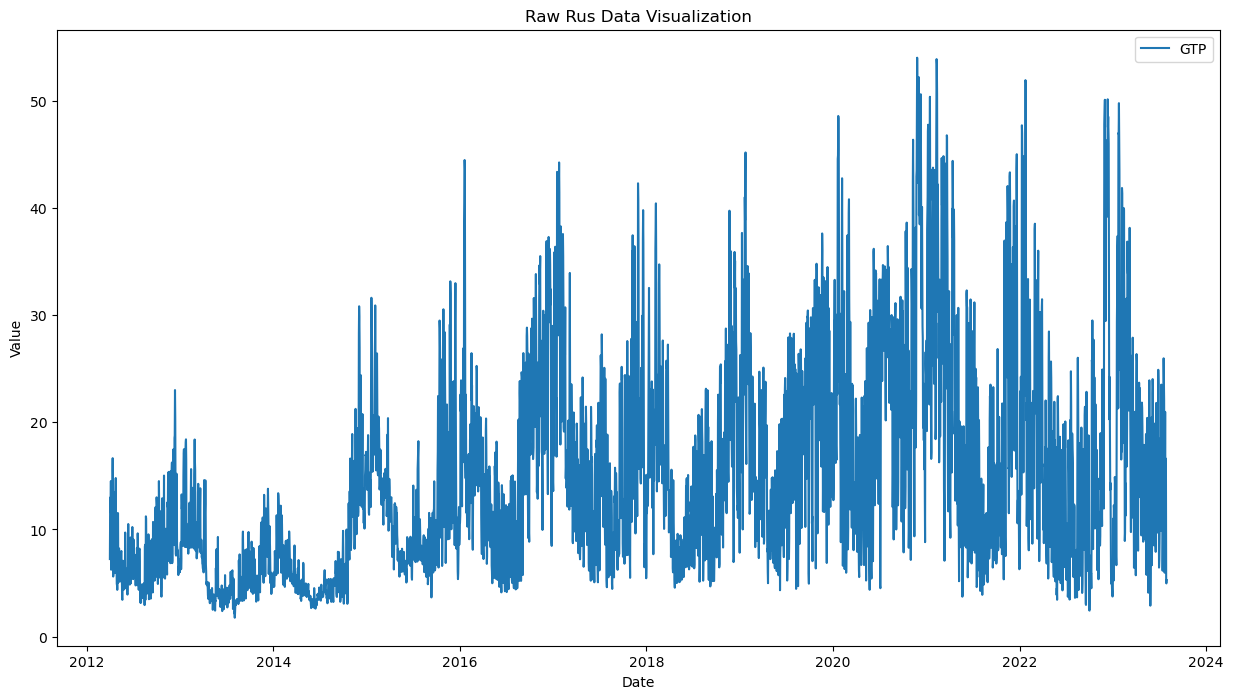

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns


# Load and preprocess the data
ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
plt.plot(ngd_data['Date'], ngd_data['GTP'], label='GTP')
plt.title("Raw Rus Data Visualization")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Drop NaN values in the 'Rus' series
ngd_data.dropna(subset=['GTP'], inplace=True)

# ADF test function
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # Return True if data is stationary